In [39]:
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from ALLCools.mcds import MCDS
from ALLCools.count_matrix.dataset import calculate_pv
from ALLCools.clustering import tsne, significant_pc_test, filter_regions, remove_black_list_region, lsi, binarize_matrix
from ALLCools.plot import *
from scipy.sparse import csr_matrix

In [9]:
null_ratio = 0.5
cov_ratio = 0.1
mc_type = 'CGN'

In [7]:
# change this to the paths to your MCDS files, 
# ALLCools.MCDS can handle multiple MCDS files automatically
mcds_path = 'simulated.mcds'

# Dimension name used to do clustering
# This corresponding to AnnData .obs and .var
obs_dim = 'cell'  # observation
var_dim = 'chrom100k'  # feature

# PC cutoff
pc_cutoff = 0.1

# KNN
knn = -1  # -1 means auto determine

# Leiden
resolution = 1

In [10]:
mcds = MCDS.open(
    mcds_path, 
    obs_dim='cell')
total_feature = mcds.get_index(var_dim).size
mcds = mcds.expand_dims(dim={'mc_type': [mc_type]}) # coord name doesn't matter

In [19]:
data = calculate_pv(mcds['chrom100k_da'].squeeze().transpose(
    'cell', 'chrom100k', 'count_type'),
                    reverse_value=False,
                    obs_dim='cell',
                    var_dim='chrom100k',
                    cutoff=0.5)

In [51]:
true_labels = pd.read_csv('true_labels.csv', index_col=0)

In [40]:
mcad = anndata.AnnData(X=csr_matrix(data.values),
                        obs=pd.DataFrame([], index=data.get_index('cell')),
                        var=pd.DataFrame([],
                                         index=data.get_index('chrom100k')))

/home/hanliu/miniconda3/envs/allcools_new/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [53]:
for col, data in true_labels.items():
    mcad.obs[col] = data

In [56]:
cell_sum = mcds['chrom100k_da'].sum(dim='chrom100k')
cell_frac = cell_sum.sel(count_type='mc') / cell_sum.sel(count_type='cov')
mcad.obs['cell_frac'] = cell_frac.squeeze().to_pandas()
mcad.obs['cell_cov'] = cell_sum.sel(count_type='cov').squeeze().to_pandas()

In [43]:
binarize_matrix(mcad, cutoff=0.95)

In [44]:
filter_regions(mcad, hypo_cutoff=6)

In [45]:
# by default we save the results in adata.obsm['X_pca'] which is the scanpy defaults in many following functions
# But this matrix is not calculated by PCA
lsi(mcad, algorithm='arpack', obsm='X_pca')

TruncatedSVD(algorithm='arpack', n_components=100, random_state=0)

In [46]:
# choose significant components
significant_pc_test(mcad, p_cutoff=pc_cutoff, update=True)

4 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (1143, 100) to (1143, 4)


4

In [47]:
if knn == -1:
    knn = max(15, int(np.log2(mcad.shape[0])*2))
sc.pp.neighbors(mcad, n_neighbors=knn)

In [48]:
sc.tl.leiden(mcad, resolution=resolution)

In [49]:
tsne(mcad,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)

[Text(0.5, 1.0, 'True Cluster')]

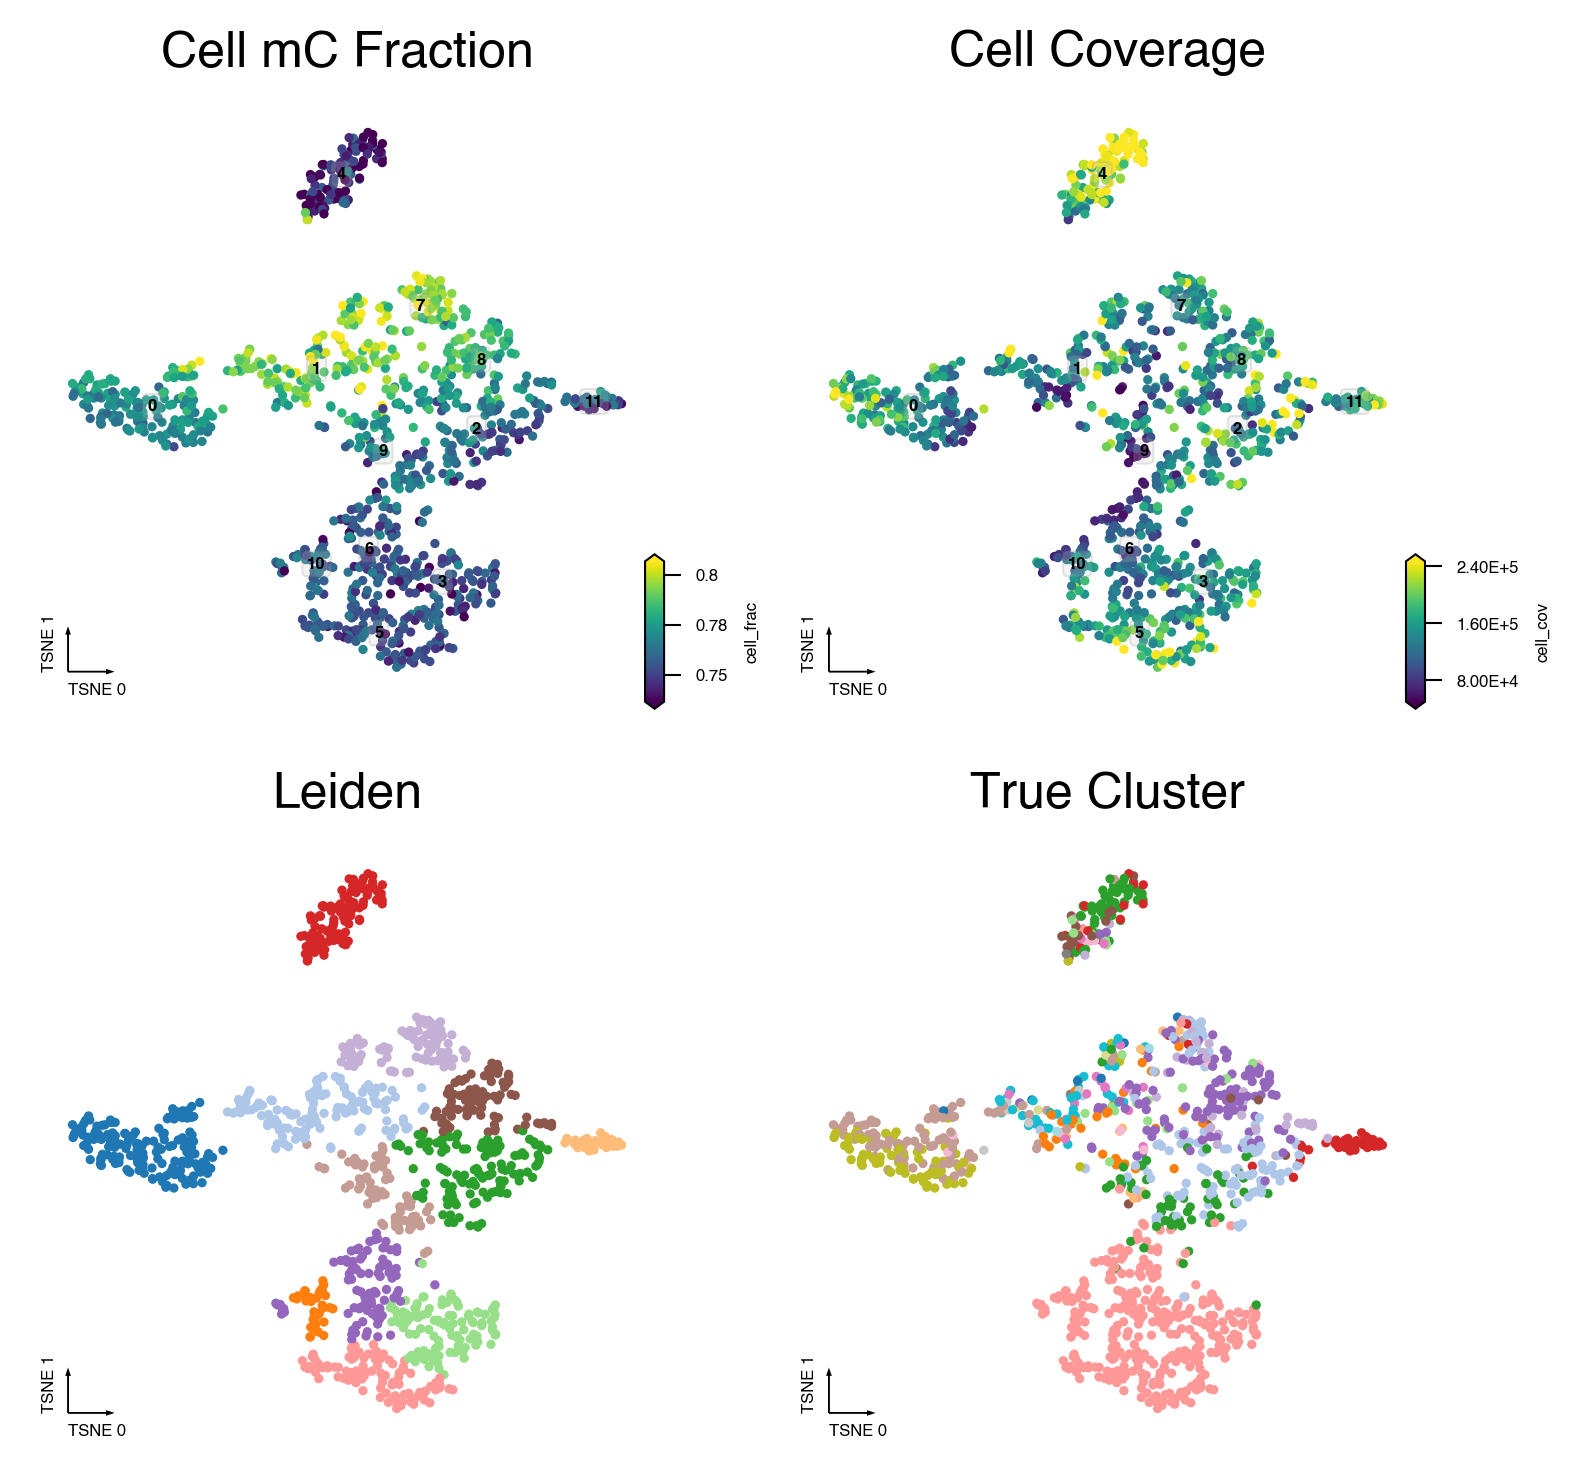

In [57]:
fig, axes = plt.subplots(figsize=(6, 6), dpi=300, ncols=2, nrows=2)

ax = axes[0, 0]
_ = continuous_scatter(data=mcad,
                        ax=ax,
                        coord_base='tsne',
                        hue='cell_frac',
                        text_anno='leiden')
ax.set(title='Cell mC Fraction')
ax = axes[0, 1]
_ = continuous_scatter(data=mcad,
                        ax=ax,
                        coord_base='tsne',
                        hue='cell_cov',
                        text_anno='leiden')
ax.set(title='Cell Coverage')


ax = axes[1, 0]
_ = categorical_scatter(data=mcad,
                        ax=ax,
                        coord_base='tsne',
                        hue='leiden',
                        # text_anno='leiden',
                        show_legend=False)
ax.set(title='Leiden')

ax = axes[1, 1]
_ = categorical_scatter(data=mcad,
                        ax=ax,
                        coord_base='tsne',
                        hue='L2',
                        palette='tab20',
                        # text_anno='L2',
                        show_legend=False)
ax.set(title='True Cluster')